In [ ]:
# check GPU
import torch

if torch.cuda.is_available():
    print("CUDA is available! You can use device='cuda'.")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is NOT available. Only CPU is available.")


CUDA is available! You can use device='cuda'.
Number of CUDA devices: 1
Current CUDA device: 0
Device name: NVIDIA GeForce GTX 1660 SUPER


In [ ]:
# Load the file and print the info
import scipy.io
import numpy as np

def load_ninapro_exA(file_path):
    data = scipy.io.loadmat(file_path)
    emg = data['emg']  # shape: (n_samples, 10)
    stimulus = data['stimulus'].flatten()
    mask = np.isin(stimulus, np.arange(0, 13))
    emg_sel = emg[mask]
    stim_sel = stimulus[mask]
    return emg_sel, stim_sel

file_path = 's2\\S2_A1_E1.mat'
X, y = load_ninapro_exA(file_path)

unique, counts = np.unique(y, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("EMG shape:", X.shape)
print("Stimulus shape:", y.shape)
print("Class distribution:", class_distribution)


EMG shape: (100686, 10)
Stimulus shape: (100686,)
Class distribution: {0: 38842, 1: 5120, 2: 5169, 3: 5130, 4: 5161, 5: 5169, 6: 5170, 7: 5165, 8: 5169, 9: 5130, 10: 5128, 11: 5167, 12: 5166}



===== Window Length = 0.25s =====

===== Window Length = 0.5s =====


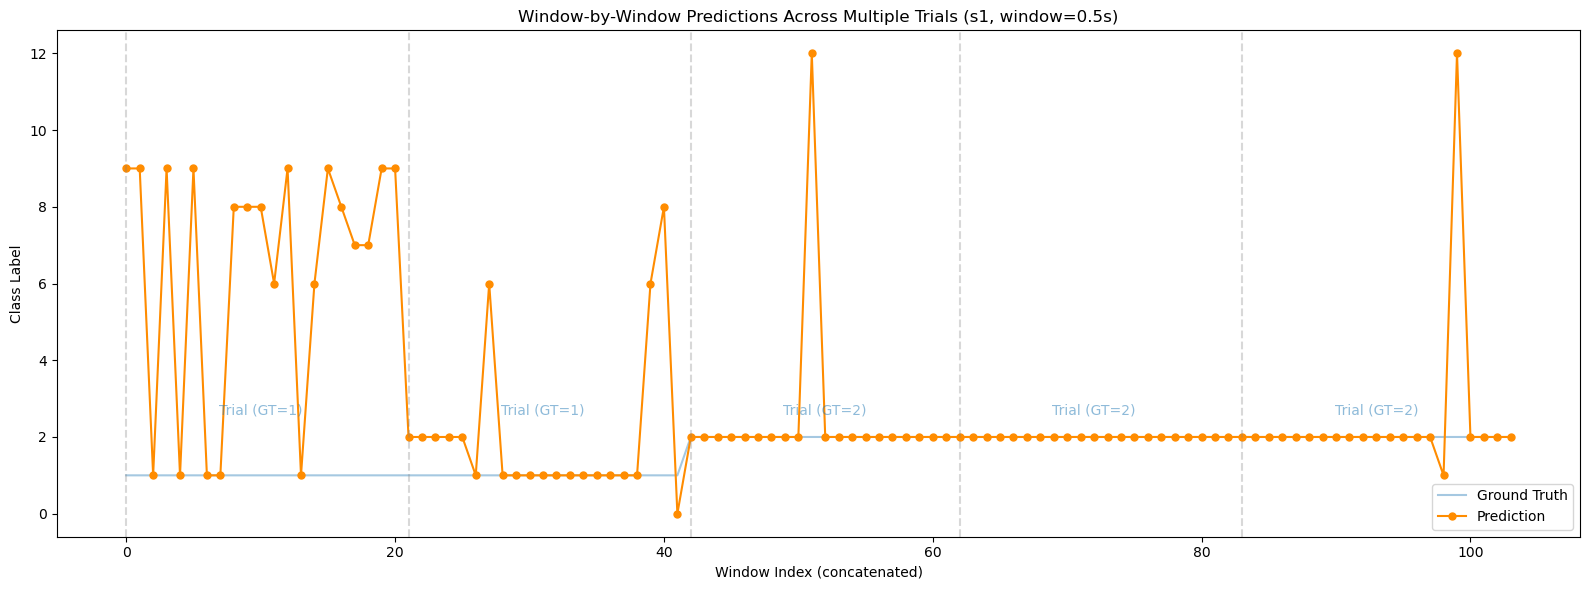


===== Window Length = 1.0s =====


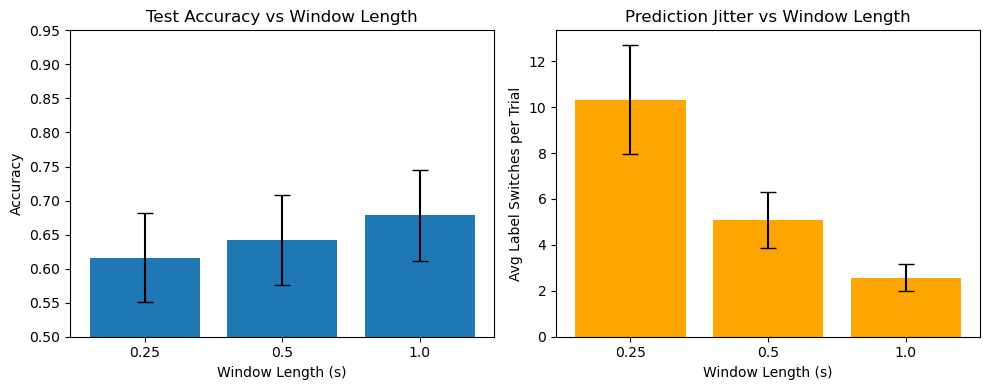

In [35]:
# Exp0: Window length vs jitter
import os
import numpy as np
import scipy.io
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# ==== 參數設置 ====
DATA_DIR = r'C:\Users\wangc\Desktop\np'
SUBJECTS = [f"s{i}" for i in range(1, 28)]
WINDOW_LENGTHS = [0.25, 0.5, 1.0]
OVERLAP = 0.5
FS = 100
RANDOM_STATE = 42
PCA_N_COMPONENTS = 0.95

# ---- Sliding Window & Trial Segmentation ----
def load_ninapro_exA(file_path):
    data = scipy.io.loadmat(file_path)
    emg = data['emg']  # shape: (n_samples, 10)
    stimulus = data['stimulus'].flatten()
    mask = np.isin(stimulus, np.arange(0, 13))  # 0~12, 13 classes (含rest)
    emg_sel = emg[mask]
    stim_sel = stimulus[mask]
    return emg_sel, stim_sel

def extract_trials(y):
    trials = []
    start = 0
    current_label = y[0]
    for i in range(1, len(y)):
        if y[i] != current_label:
            trials.append((start, i, current_label))
            start = i
            current_label = y[i]
    trials.append((start, len(y), current_label))
    return trials

def create_sliding_windows(X, y, window_sec=1.0, overlap=0.5, fs=100):
    window_size = int(window_sec * fs)
    step_size = int(window_size * (1 - overlap))
    X_windows, y_windows, trial_ids = [], [], []
    cur_trial = 0
    last_label = y[0]
    for start in range(0, len(X) - window_size + 1, step_size):
        window = X[start:start+window_size, :]
        label = y[start + window_size // 2]
        if label != last_label:
            cur_trial += 1
            last_label = label
        X_windows.append(window.flatten())
        y_windows.append(label)
        trial_ids.append(cur_trial)
    return np.array(X_windows), np.array(y_windows), np.array(trial_ids)

def balance_data_by_trial(X, y, trial_ids):
    # 保證每個類別(trial label)數量一致，每個 trial 為單位
    np.random.seed(RANDOM_STATE)
    trial_labels = []
    unique_trials = np.unique(trial_ids)
    for tid in unique_trials:
        idx = np.where(trial_ids == tid)[0]
        label = y[idx[0]]
        trial_labels.append(label)
    trial_labels = np.array(trial_labels)
    classes, counts = np.unique(trial_labels, return_counts=True)
    min_count = counts.min()
    keep_trials = []
    for cls in classes:
        trial_idx = np.where(trial_labels == cls)[0]
        select = np.random.choice(trial_idx, min_count, replace=False)
        keep_trials.extend(unique_trials[select])
    keep_trials = np.array(keep_trials)
    keep_mask = np.isin(trial_ids, keep_trials)
    return X[keep_mask], y[keep_mask], trial_ids[keep_mask]

def count_label_switches(pred_labels):
    return np.sum(pred_labels[1:] != pred_labels[:-1])

summary = {wl: {'acc':[], 'jitter':[]} for wl in WINDOW_LENGTHS}

for window_sec in WINDOW_LENGTHS:
    print(f"\n===== Window Length = {window_sec}s =====")
    for subj in SUBJECTS:
        mat_file = os.path.join(DATA_DIR, subj, f"{subj.upper()}_A1_E1.mat")
        if not os.path.exists(mat_file):
            continue
        X, y = load_ninapro_exA(mat_file)
        Xw, yw, trial_ids = create_sliding_windows(X, y, window_sec=window_sec, overlap=OVERLAP, fs=FS)

        # 以 trial 為單位進行 balanced
        Xw, yw, trial_ids = balance_data_by_trial(Xw, yw, trial_ids)

        # 用 trial id 切分 train/test（80/20），完全 trial-based split
        unique_trials = np.unique(trial_ids)
        np.random.seed(RANDOM_STATE)
        np.random.shuffle(unique_trials)
        n_train = int(len(unique_trials) * 0.8)
        train_trial_ids = unique_trials[:n_train]
        test_trial_ids  = unique_trials[n_train:]

        train_mask = np.isin(trial_ids, train_trial_ids)
        test_mask  = np.isin(trial_ids, test_trial_ids)

        X_train, y_train, tid_train = Xw[train_mask], yw[train_mask], trial_ids[train_mask]
        X_test,  y_test,  tid_test  = Xw[test_mask],  yw[test_mask],  trial_ids[test_mask]

        # 標準化 + PCA（train fit, test transform）
        scaler = StandardScaler()
        X_train_std = scaler.fit_transform(X_train)
        X_test_std  = scaler.transform(X_test)
        pca = PCA(n_components=PCA_N_COMPONENTS, random_state=RANDOM_STATE)
        X_train_pca = pca.fit_transform(X_train_std)
        X_test_pca  = pca.transform(X_test_std)

        rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced')
        rf.fit(X_train_pca, y_train)
        y_pred = rf.predict(X_test_pca)
        acc = np.mean(y_pred == y_test)
        summary[window_sec]['acc'].append(acc)

        # jitter: 每 trial 平均 label switch
        test_trials = np.unique(tid_test)
        trial_switches = []
        for tid in test_trials:
            idx = np.where(tid_test == tid)[0]
            trial_pred = y_pred[idx]
            trial_switches.append(count_label_switches(trial_pred))
        summary[window_sec]['jitter'].append(np.mean(trial_switches))

        if subj == 's1' and window_sec == 0.5:
            n_trials_to_show = 5
            # 挑出 test set 前 N 個 trial 的 window index
            show_trials = test_trials[:n_trials_to_show]
            x_concat = []
            gt_concat = []
            pred_concat = []
            label_pos = []  # for trial label bar
            cur = 0
            for tid in show_trials:
                idx = np.where(tid_test == tid)[0]
                x_concat.extend(range(cur, cur + len(idx)))
                gt_concat.extend(y_test[idx])
                pred_concat.extend(y_pred[idx])
                label_pos.append((cur + len(idx)//2, y_test[idx][0]))  # trial中心
                cur += len(idx)

            plt.figure(figsize=(16,6))
            plt.plot(x_concat, gt_concat, '-', color='C0', alpha=0.4, label='Ground Truth')
            plt.plot(x_concat, pred_concat, '-o', color='darkorange', markersize=5, label='Prediction')
            # 可加上 trial 分界線
            cur = 0
            for tid in show_trials:
                idx = np.where(tid_test == tid)[0]
                plt.axvline(cur, color='gray', linestyle='--', alpha=0.3)
                cur += len(idx)
            # 可加 trial 編號與 label
            for pos, lab in label_pos:
                plt.text(pos, max(gt_concat)+0.5, f'Trial (GT={int(lab)})', fontsize=10, ha='center', va='bottom', color='C0', alpha=0.5)
            plt.xlabel("Window Index (concatenated)")
            plt.ylabel("Class Label")
            plt.title("Window-by-Window Predictions Across Multiple Trials (s1, window=0.5s)")
            plt.legend()
            plt.tight_layout()
            plt.show()

# ---- 結果圖表 ----
plt.figure(figsize=(10,4))
means_acc = [np.mean(summary[wl]['acc']) for wl in WINDOW_LENGTHS]
stds_acc = [np.std(summary[wl]['acc']) for wl in WINDOW_LENGTHS]
means_jitter = [np.mean(summary[wl]['jitter']) for wl in WINDOW_LENGTHS]
stds_jitter = [np.std(summary[wl]['jitter']) for wl in WINDOW_LENGTHS]

plt.subplot(1,2,1)
plt.bar([str(w) for w in WINDOW_LENGTHS], means_acc, yerr=stds_acc, capsize=6)
plt.ylim(0.5, 0.95)
plt.ylabel("Accuracy")
plt.xlabel("Window Length (s)")
plt.title("Test Accuracy vs Window Length")

plt.subplot(1,2,2)
plt.bar([str(w) for w in WINDOW_LENGTHS], means_jitter, yerr=stds_jitter, capsize=6, color='orange')
plt.ylabel("Avg Label Switches per Trial")
plt.xlabel("Window Length (s)")
plt.title("Prediction Jitter vs Window Length")
plt.tight_layout()
plt.show()


Selected trial IDs: [3, 25, 43, 69]
Their labels: [1, 2, 3, 4]


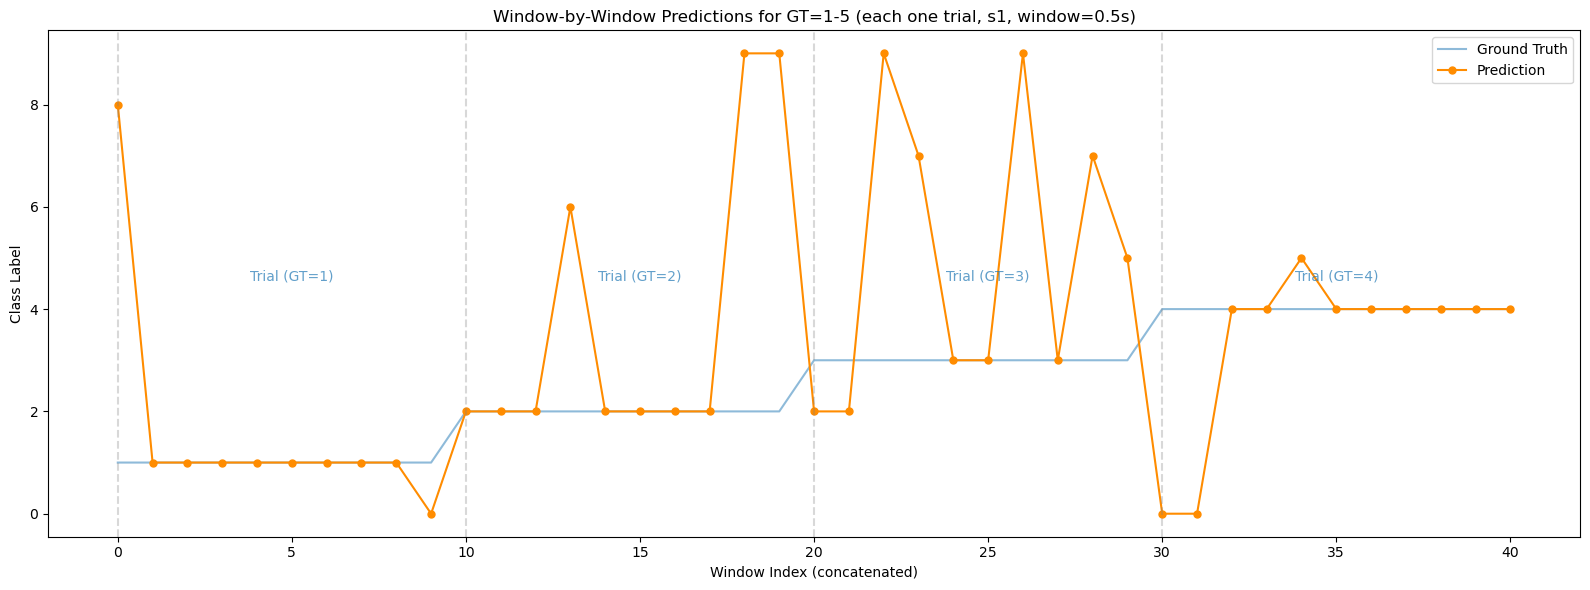

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# 找出每個 label（1~5）對應的 trial id
selected_trials = []
used_labels = set()
for tid in np.unique(tid_test):
    idx = np.where(tid_test == tid)[0]
    label = y_test[idx][0]
    # 只挑1~5 label且每label只取一個
    if 1 <= label <= 5 and label not in used_labels:
        selected_trials.append(tid)
        used_labels.add(label)
    if len(selected_trials) == 5:
        break

# 檢查結果
print("Selected trial IDs:", selected_trials)
print("Their labels:", [y_test[np.where(tid_test == tid)[0]][0] for tid in selected_trials])

# 拼接並畫圖
x_concat, gt_concat, pred_concat, label_pos = [], [], [], []
cur = 0
for tid in selected_trials:
    idx = np.where(tid_test == tid)[0]
    x_concat.extend(range(cur, cur + len(idx)))
    gt_concat.extend(y_test[idx])
    pred_concat.extend(y_pred[idx])
    label_pos.append((cur + len(idx)//2, y_test[idx][0]))
    cur += len(idx)

plt.figure(figsize=(16,6))
plt.plot(x_concat, gt_concat, '-', color='C0', alpha=0.5, label='Ground Truth')
plt.plot(x_concat, pred_concat, '-o', color='darkorange', markersize=5, label='Prediction')
cur = 0
for tid in selected_trials:
    idx = np.where(tid_test == tid)[0]
    plt.axvline(cur, color='gray', linestyle='--', alpha=0.3)
    cur += len(idx)
for pos, lab in label_pos:
    plt.text(pos, max(gt_concat)+0.5, f'Trial (GT={int(lab)})', fontsize=10, ha='center', va='bottom', color='C0', alpha=0.7)
plt.xlabel("Window Index (concatenated)")
plt.ylabel("Class Label")
plt.title("Window-by-Window Predictions for GT=1-5 (each one trial, s1, window=0.5s)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Exp1: Baseline (No PCA, Real-time) Experiment
import os
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle

def load_ninapro_exA(file_path):
    data = scipy.io.loadmat(file_path)
    emg = data['emg']  # (n_samples, 10)
    stimulus = data['stimulus'].flatten()
    mask = np.isin(stimulus, np.arange(1, 14))  # 1~13: 12動作+rest
    emg_sel = emg[mask]
    stim_sel = stimulus[mask]
    return emg_sel, stim_sel

def create_sliding_windows(X, y, window_sec=0.5, overlap=0.5, fs=100):
    window_size = int(window_sec * fs)
    step_size = int(window_size * (1 - overlap))
    X_windows, y_windows = [], []
    for start in range(0, len(X) - window_size + 1, step_size):
        window = X[start:start+window_size, :]
        label = y[start + window_size // 2]
        X_windows.append(window.flatten())
        y_windows.append(label)
    return np.array(X_windows), np.array(y_windows)

def balance_and_split(X, y, train_ratio=0.8, random_state=42):
    np.random.seed(random_state)
    X_train, y_train, X_test, y_test = [], [], [], []
    classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()
    for cls in classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        n_train = int(min_count * train_ratio)
        idx_sel = idx[:min_count]
        idx_train = idx_sel[:n_train]
        idx_test = idx_sel[n_train:]
        X_train.append(X[idx_train])
        y_train.append(y[idx_train])
        X_test.append(X[idx_test])
        y_test.append(y[idx_test])
    return (np.concatenate(X_train), np.concatenate(y_train),
            np.concatenate(X_test), np.concatenate(y_test))

# ====== 主要流程 ======
DATA_DIR = r'C:\Users\wangc\Desktop\np'
SUBJECTS = [f"s{i}" for i in range(1, 28)]
MODEL_NAMES = ['KNN', 'SVM', 'RF']

knn_param_grid = {
    'n_neighbors': [1, 2, 3, 4, 5],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto']
}
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'class_weight': ['balanced'],
    'gamma': ['scale']
}
rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10, 20],
    'class_weight': ['balanced'],
    'min_samples_split': [2, 5]
}

all_acc = {name: [] for name in MODEL_NAMES}

for subj in SUBJECTS:
    mat_file = os.path.join(DATA_DIR, subj, f"{subj.upper()}_A1_E1.mat")
    if not os.path.exists(mat_file):
        print(f"File not found: {mat_file}, skip.")
        continue
    print(f"\nProcessing {mat_file}")
    X, y = load_ninapro_exA(mat_file)
    Xw, yw = create_sliding_windows(X, y, window_sec=0.5, overlap=0.5, fs=100)
    X_train, y_train, X_test, y_test = balance_and_split(Xw, yw, train_ratio=0.8, random_state=42)
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    # 無PCA，直接訓練
    knn_gs = GridSearchCV(KNeighborsClassifier(), 
                          ram_grid, cv=3, scoring='accuracy', n_jobs=-1)
    knn_gs.fit(X_train_std, y_train)
    y_pred_knn = knn_gs.predict(X_test_std)
    acc_knn = accuracy_score(y_test, y_pred_knn)
    all_acc['KNN'].append(acc_knn)

    svm_gs = GridSearchCV(SVC(), svm_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    svm_gs.fit(X_train_std, y_train)
    y_pred_svm = svm_gs.predict(X_test_std)
    acc_svm = accuracy_score(y_test, y_pred_svm)
    all_acc['SVM'].append(acc_svm)

    rf_gs = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    rf_gs.fit(X_train_std, y_train)
    y_pred_rf = rf_gs.predict(X_test_std)
    acc_rf = accuracy_score(y_test, y_pred_rf)
    all_acc['RF'].append(acc_rf)

    print(f"  KNN acc: {acc_knn:.3f}  SVM acc: {acc_svm:.3f}  RF acc: {acc_rf:.3f}")

print("\n==== Across 27 Subjects (Baseline, Sliding Window) ====")
for name in MODEL_NAMES:
    accs = np.array(all_acc[name])
    print(f"{name} mean acc: {accs.mean():.3f}   std: {accs.std():.3f}   n={len(accs)}")

# 儲存
with open('all_acc_baseline.pkl', 'wb') as f:
    pickle.dump(all_acc, f)
print("Baseline results saved to all_acc_baseline.pkl!")



Processing C:\Users\wangc\Desktop\np\s1\S1_A1_E1.mat
  KNN acc: 0.715  SVM acc: 0.679  RF acc: 0.770

Processing C:\Users\wangc\Desktop\np\s2\S2_A1_E1.mat
  KNN acc: 0.622  SVM acc: 0.703  RF acc: 0.732

Processing C:\Users\wangc\Desktop\np\s3\S3_A1_E1.mat
  KNN acc: 0.671  SVM acc: 0.673  RF acc: 0.748

Processing C:\Users\wangc\Desktop\np\s4\S4_A1_E1.mat
  KNN acc: 0.689  SVM acc: 0.695  RF acc: 0.717

Processing C:\Users\wangc\Desktop\np\s5\S5_A1_E1.mat
  KNN acc: 0.596  SVM acc: 0.722  RF acc: 0.764

Processing C:\Users\wangc\Desktop\np\s6\S6_A1_E1.mat
  KNN acc: 0.663  SVM acc: 0.722  RF acc: 0.730

Processing C:\Users\wangc\Desktop\np\s7\S7_A1_E1.mat
  KNN acc: 0.793  SVM acc: 0.809  RF acc: 0.864

Processing C:\Users\wangc\Desktop\np\s8\S8_A1_E1.mat
  KNN acc: 0.587  SVM acc: 0.685  RF acc: 0.758

Processing C:\Users\wangc\Desktop\np\s9\S9_A1_E1.mat
  KNN acc: 0.644  SVM acc: 0.756  RF acc: 0.809

Processing C:\Users\wangc\Desktop\np\s10\S10_A1_E1.mat
  KNN acc: 0.740  SVM acc:

In [47]:
# Exp1: Baseline + PCA (Real-time) Experiment
import os
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import pickle

def load_ninapro_exA(file_path):
    data = scipy.io.loadmat(file_path)
    emg = data['emg']
    stimulus = data['stimulus'].flatten()
    mask = np.isin(stimulus, np.arange(1, 14))
    emg_sel = emg[mask]
    stim_sel = stimulus[mask]
    return emg_sel, stim_sel

def create_sliding_windows(X, y, window_sec=0.5, overlap=0.5, fs=100):
    window_size = int(window_sec * fs)
    step_size = int(window_size * (1 - overlap))
    X_windows, y_windows = [], []
    for start in range(0, len(X) - window_size + 1, step_size):
        window = X[start:start+window_size, :]
        label = y[start + window_size // 2]
        X_windows.append(window.flatten())
        y_windows.append(label)
    return np.array(X_windows), np.array(y_windows)

def balance_and_split(X, y, train_ratio=0.8, random_state=42):
    np.random.seed(random_state)
    X_train, y_train, X_test, y_test = [], [], [], []
    classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()
    for cls in classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        n_train = int(min_count * train_ratio)
        idx_sel = idx[:min_count]
        idx_train = idx_sel[:n_train]
        idx_test = idx_sel[n_train:]
        X_train.append(X[idx_train])
        y_train.append(y[idx_train])
        X_test.append(X[idx_test])
        y_test.append(y[idx_test])
    return (np.concatenate(X_train), np.concatenate(y_train),
            np.concatenate(X_test), np.concatenate(y_test))

# ====== 主要流程 ======
DATA_DIR = r'C:\Users\wangc\Desktop\np'
SUBJECTS = [f"s{i}" for i in range(1, 28)]
MODEL_NAMES = ['KNN', 'SVM', 'RF']
PCA_N_COMPONENTS = 0.95

knn_param_grid = {
    'n_neighbors': [1, 2, 3, 4, 5],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto']
}
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'class_weight': ['balanced'],
    'gamma': ['scale']
}
rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10, 20],
    'class_weight': ['balanced'],
    'min_samples_split': [2, 5]
}

all_acc = {name: [] for name in MODEL_NAMES}
all_pca_dims = []
all_pca_var = []

for subj in SUBJECTS:
    mat_file = os.path.join(DATA_DIR, subj, f"{subj.upper()}_A1_E1.mat")
    if not os.path.exists(mat_file):
        print(f"File not found: {mat_file}, skip.")
        continue
    print(f"\nProcessing {mat_file}")
    X, y = load_ninapro_exA(mat_file)
    Xw, yw = create_sliding_windows(X, y, window_sec=0.5, overlap=0.5, fs=100)
    X_train, y_train, X_test, y_test = balance_and_split(Xw, yw, train_ratio=0.8, random_state=42)
    # 標準化
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    # PCA
    pca = PCA(n_components=PCA_N_COMPONENTS, random_state=42)
    X_train_pca = pca.fit_transform(X_train_std)
    X_test_pca = pca.transform(X_test_std)
    all_pca_dims.append(X_train_pca.shape[1])
    all_pca_var.append(pca.explained_variance_ratio_.sum())
    print(f"    PCA: {X_train_std.shape[1]} -> {X_train_pca.shape[1]} dims, explained variance={pca.explained_variance_ratio_.sum():.2f}")

    knn_gs = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    knn_gs.fit(X_train_pca, y_train)
    y_pred_knn = knn_gs.predict(X_test_pca)
    acc_knn = accuracy_score(y_test, y_pred_knn)
    all_acc['KNN'].append(acc_knn)

    svm_gs = GridSearchCV(SVC(), svm_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    svm_gs.fit(X_train_pca, y_train)
    y_pred_svm = svm_gs.predict(X_test_pca)
    acc_svm = accuracy_score(y_test, y_pred_svm)
    all_acc['SVM'].append(acc_svm)

    rf_gs = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    rf_gs.fit(X_train_pca, y_train)
    y_pred_rf = rf_gs.predict(X_test_pca)
    acc_rf = accuracy_score(y_test, y_pred_rf)
    all_acc['RF'].append(acc_rf)

    print(f"  KNN acc: {acc_knn:.3f}  SVM acc: {acc_svm:.3f}  RF acc: {acc_rf:.3f}")

print("\n==== Across 27 Subjects (PCA+Sliding Window) ====")
for name in MODEL_NAMES:
    accs = np.array(all_acc[name])
    print(f"{name} mean acc: {accs.mean():.3f}   std: {accs.std():.3f}   n={len(accs)}")
print(f"PCA explained variance (mean): {np.mean(all_pca_var):.3f}")
print(f"PCA kept dimensions (mean): {np.mean(all_pca_dims):.1f}")

with open('all_acc_pca.pkl', 'wb') as f:
    pickle.dump({'acc': all_acc, 'pca_dims': all_pca_dims, 'pca_var': all_pca_var}, f)
print("Results saved to all_acc_pca.pkl!")



Processing C:\Users\wangc\Desktop\np\s1\S1_A1_E1.mat
    PCA: 500 -> 16 dims, explained variance=0.95
  KNN acc: 0.724  SVM acc: 0.699  RF acc: 0.732

Processing C:\Users\wangc\Desktop\np\s2\S2_A1_E1.mat
    PCA: 500 -> 16 dims, explained variance=0.95
  KNN acc: 0.657  SVM acc: 0.707  RF acc: 0.713

Processing C:\Users\wangc\Desktop\np\s3\S3_A1_E1.mat
    PCA: 500 -> 12 dims, explained variance=0.95
  KNN acc: 0.695  SVM acc: 0.646  RF acc: 0.703

Processing C:\Users\wangc\Desktop\np\s4\S4_A1_E1.mat
    PCA: 500 -> 18 dims, explained variance=0.95
  KNN acc: 0.691  SVM acc: 0.705  RF acc: 0.738

Processing C:\Users\wangc\Desktop\np\s5\S5_A1_E1.mat
    PCA: 500 -> 29 dims, explained variance=0.95
  KNN acc: 0.624  SVM acc: 0.693  RF acc: 0.693

Processing C:\Users\wangc\Desktop\np\s6\S6_A1_E1.mat
    PCA: 500 -> 22 dims, explained variance=0.95
  KNN acc: 0.673  SVM acc: 0.740  RF acc: 0.703

Processing C:\Users\wangc\Desktop\np\s7\S7_A1_E1.mat
    PCA: 500 -> 20 dims, explained varia

KNN mean acc: 0.7355483144778538 std: 0.07940481485165488
SVM mean acc: 0.746083724064754 std: 0.07121510283435911
RF mean acc: 0.7723881934586542 std: 0.06405789096290379


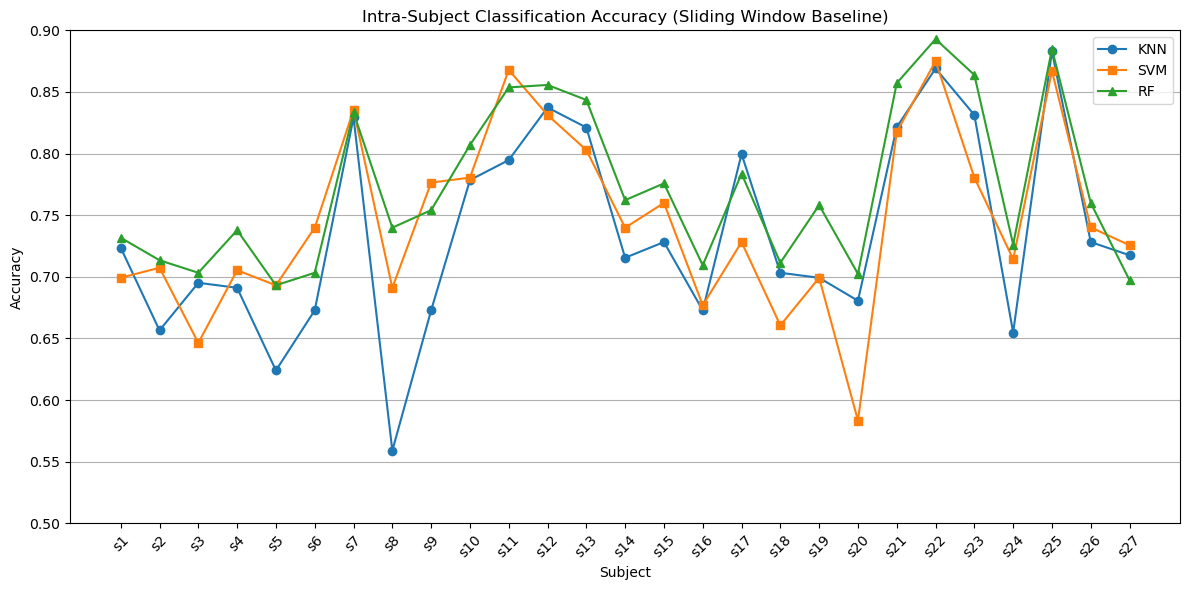

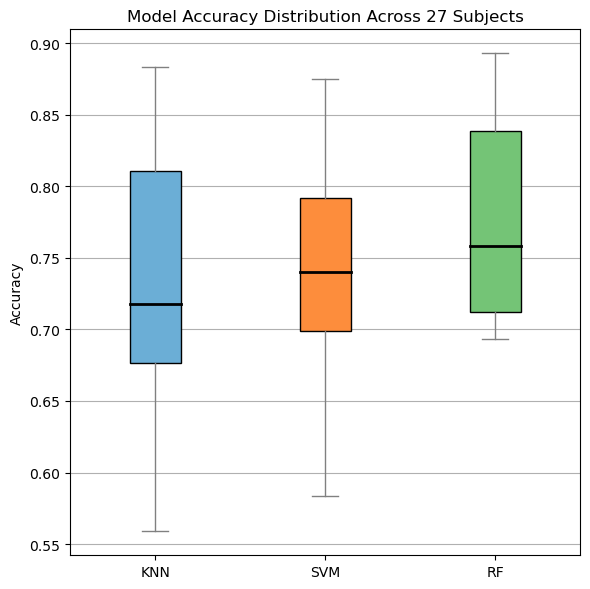

In [34]:
# plot for exp1
import matplotlib.pyplot as plt
import numpy as np

subjects = [f's{i}' for i in range(1, 28)]


knn_acc = all_acc['KNN']
svm_acc = all_acc['SVM']
rf_acc  = all_acc['RF']

print('KNN mean acc:', np.mean(knn_acc), 'std:', np.std(knn_acc))
print('SVM mean acc:', np.mean(svm_acc), 'std:', np.std(svm_acc))
print('RF mean acc:', np.mean(rf_acc), 'std:', np.std(rf_acc))

plt.figure(figsize=(12, 6))
plt.plot(subjects, knn_acc, marker='o', label='KNN')
plt.plot(subjects, svm_acc, marker='s', label='SVM')
plt.plot(subjects, rf_acc, marker='^', label='RF')
plt.xticks(rotation=45)
plt.ylim(0.5, 0.9)
plt.ylabel('Accuracy')
plt.xlabel('Subject')
plt.title('Intra-Subject Classification Accuracy (Sliding Window Baseline)')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 6))
box = plt.boxplot(
    [knn_acc, svm_acc, rf_acc],
    labels=['KNN', 'SVM', 'RF'],
    patch_artist=True 
)

# 設定顏色
colors = ['#6baed6', '#fd8d3c', '#74c476']  # 藍/橘/綠

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
for median in box['medians']:
    median.set_color('black')
    median.set_linewidth(2)
for whisker in box['whiskers']:
    whisker.set_color('gray')
    whisker.set_linewidth(1)
for cap in box['caps']:
    cap.set_color('gray')
    cap.set_linewidth(1)

plt.ylabel('Accuracy')
plt.title('Model Accuracy Distribution Across 27 Subjects')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


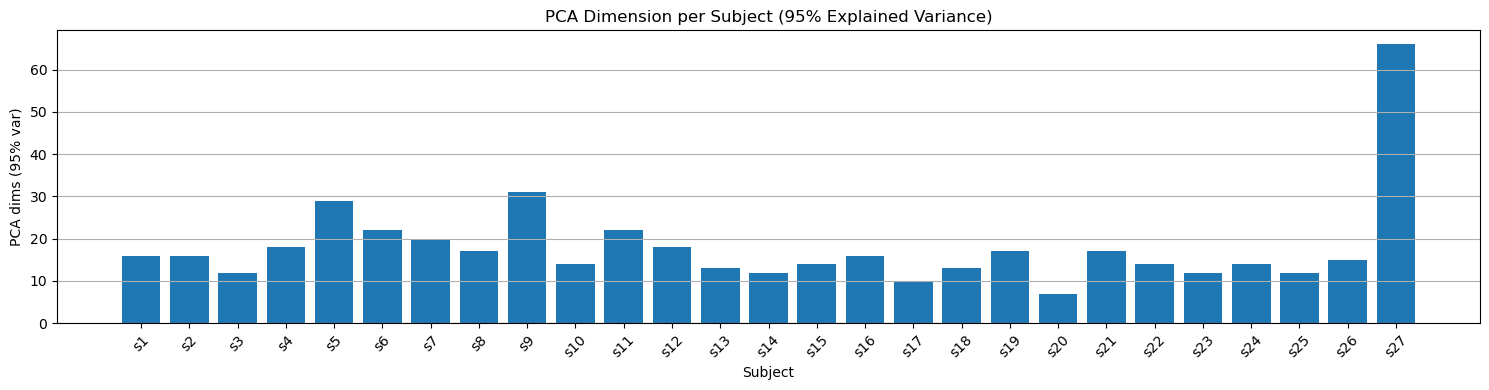

In [44]:
# Plot for PCA dim
import pickle
import matplotlib.pyplot as plt

# 載入上一步存的結果
with open('all_acc_pca.pkl', 'rb') as f:
    data = pickle.load(f)
all_acc = data['acc']  # dict: {'KNN': [...], 'SVM': [...], 'RF': [...]}
pca_dims = data['pca_dims']
pca_var = data['pca_var']

subjects = [f's{i}' for i in range(1, 28)]

# PCA維度分布圖
plt.figure(figsize=(15,4))
plt.bar(subjects, pca_dims, color='tab:blue')
plt.xticks(rotation=45)
plt.ylabel('PCA dims (95% var)')
plt.xlabel('Subject')
plt.title('PCA Dimension per Subject (95% Explained Variance)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


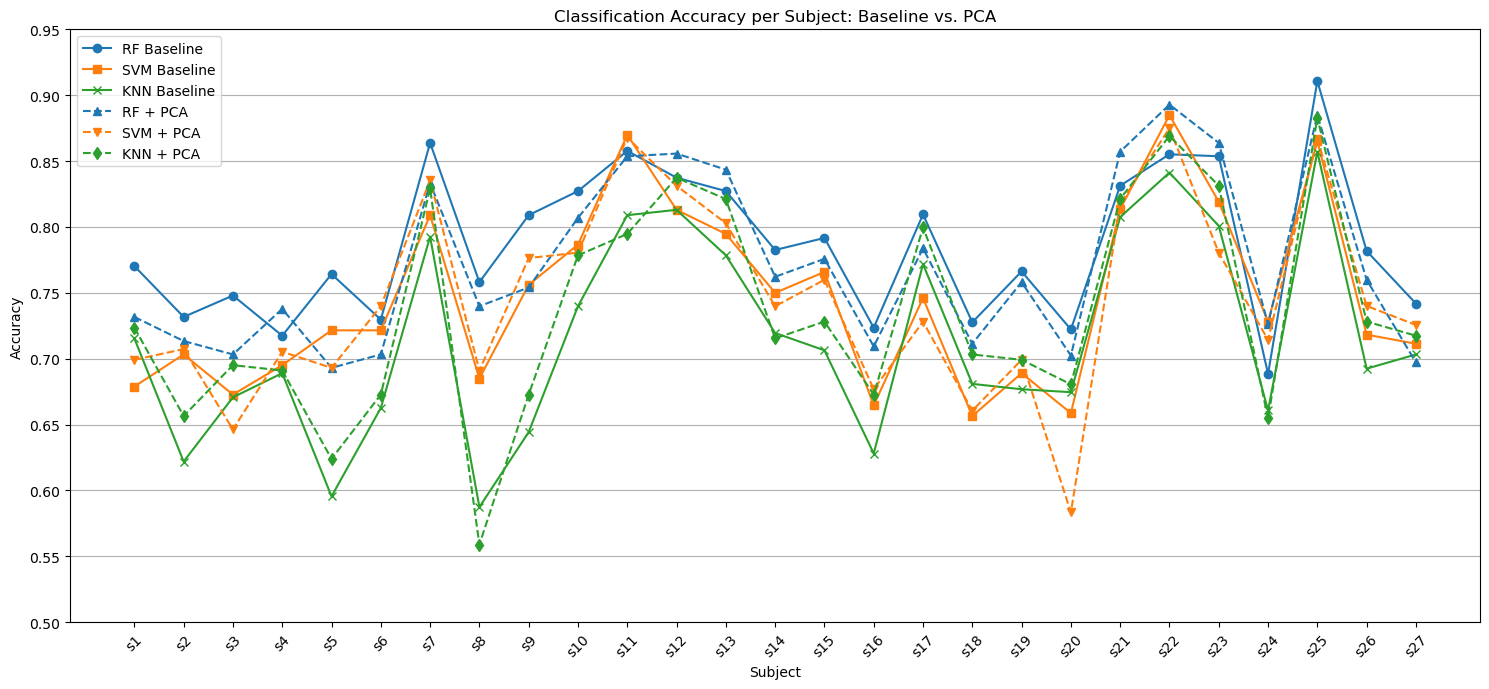

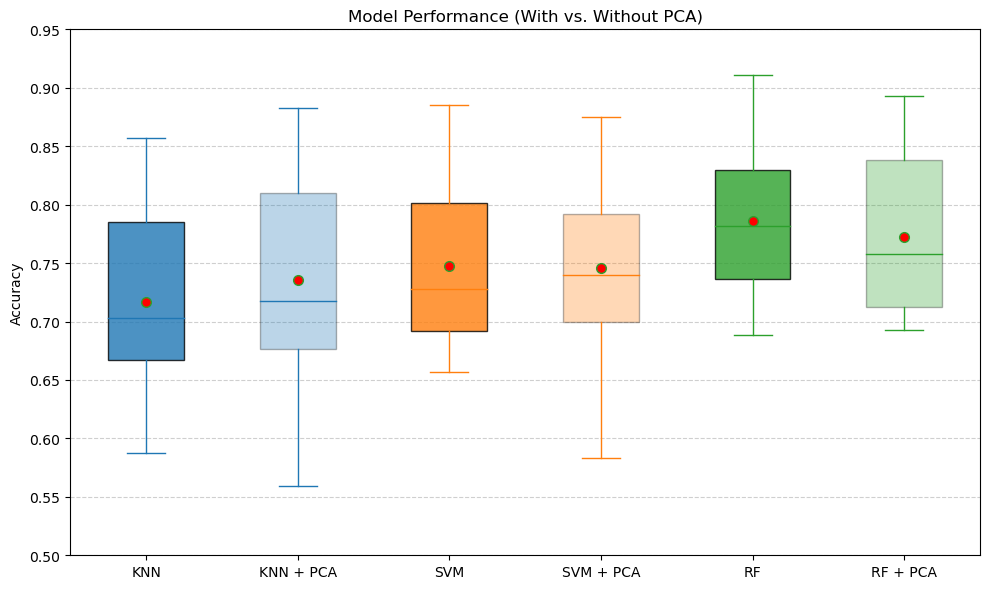

==== Baseline ====
KNN: mean = 0.716, std = 0.074
SVM: mean = 0.747, std = 0.066
RF: mean = 0.786, std = 0.055
==== PCA ====
KNN + PCA: mean = 0.736, std = 0.079
SVM + PCA: mean = 0.746, std = 0.071
RF + PCA: mean = 0.772, std = 0.064


In [51]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

subjects = [f's{i}' for i in range(1, 28)]

# 1. 讀入 baseline 跟 PCA 結果
with open('all_acc_baseline.pkl', 'rb') as f:
    data_base = pickle.load(f)
with open('all_acc_pca.pkl', 'rb') as f:
    data_pca = pickle.load(f)

# Baseline 只存acc dict，PCA是acc在data_pca['acc']
# 這裡加判斷
if isinstance(data_base, dict) and 'KNN' in data_base:
    knn_base = data_base['KNN']
    svm_base = data_base['SVM']
    rf_base  = data_base['RF']
elif isinstance(data_base, dict) and 'acc' in data_base:  # in case baseline也用新格式
    knn_base = data_base['acc']['KNN']
    svm_base = data_base['acc']['SVM']
    rf_base  = data_base['acc']['RF']

if 'acc' in data_pca:
    knn_pca  = data_pca['acc']['KNN']
    svm_pca  = data_pca['acc']['SVM']
    rf_pca   = data_pca['acc']['RF']
else:
    knn_pca  = data_pca['KNN']
    svm_pca  = data_pca['SVM']
    rf_pca   = data_pca['RF']

# --- 線圖 ---
plt.figure(figsize=(15, 7))
# Baseline (實線)
plt.plot(subjects, rf_base, marker='o', linestyle='-', color='tab:blue', label='RF Baseline')
plt.plot(subjects, svm_base, marker='s', linestyle='-', color='tab:orange', label='SVM Baseline')
plt.plot(subjects, knn_base, marker='x', linestyle='-', color='tab:green', label='KNN Baseline')
# PCA (虛線)
plt.plot(subjects, rf_pca, marker='^', linestyle='--', color='tab:blue', label='RF + PCA')
plt.plot(subjects, svm_pca, marker='v', linestyle='--', color='tab:orange', label='SVM + PCA')
plt.plot(subjects, knn_pca, marker='d', linestyle='--', color='tab:green', label='KNN + PCA')
plt.xticks(rotation=45)
plt.ylim(0.5, 0.95)
plt.ylabel('Accuracy')
plt.xlabel('Subject')
plt.title('Classification Accuracy per Subject: Baseline vs. PCA')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# --- 箱型圖 ---
data = [
    knn_base, knn_pca,
    svm_base, svm_pca,
    rf_base,  rf_pca
]
labels = [
    "KNN", "KNN + PCA",
    "SVM", "SVM + PCA",
    "RF",  "RF + PCA"
]
colors = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:green', 'tab:green']
alphas = [0.8, 0.3, 0.8, 0.3, 0.8, 0.3]  # Baseline 深色, PCA 淺色

plt.figure(figsize=(10, 6))
box = plt.boxplot(data, labels=labels, showmeans=True, patch_artist=True)
for patch, color, alpha in zip(box['boxes'], colors, alphas):
    patch.set_facecolor(color)
    patch.set_alpha(alpha)
for median, color in zip(box['medians'], colors):
    median.set_color(color)
for mean, color in zip(box['means'], colors):
    mean.set_markerfacecolor('red')
    mean.set_marker('o')
    mean.set_markersize(7)
for whisker, color in zip(box['whiskers'], np.repeat(colors, 2)):
    whisker.set_color(color)
for cap, color in zip(box['caps'], np.repeat(colors, 2)):
    cap.set_color(color)
plt.ylabel("Accuracy")
plt.title("Model Performance (With vs. Without PCA)")
plt.ylim(0.5, 0.95)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



# 計算平均與標準差
def print_model_stats(name, arr):
    print(f"{name}: mean = {np.mean(arr):.3f}, std = {np.std(arr):.3f}")

print("==== Baseline ====")
print_model_stats("KNN", knn_base)
print_model_stats("SVM", svm_base)
print_model_stats("RF", rf_base)

print("==== PCA ====")
print_model_stats("KNN + PCA", knn_pca)
print_model_stats("SVM + PCA", svm_pca)
print_model_stats("RF + PCA", rf_pca)



In [52]:
# exp2 with PCA
import os
import numpy as np
from scipy.stats import mode
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle

# ==== 參數設置 ====
DATA_DIR = r'C:\Users\wangc\Desktop\np'
SUBJECTS = [f"s{i}" for i in range(1, 28)]
WINDOW_SEC = 0.5
OVERLAP = 0.5
FS = 200
N_TRAIN_PER_CLASS = 60
N_TEST_PER_CLASS = 22
TRIGGER_N_LIST = [1, 2, 3, 4, 5, 6]

# ==== PCA參數 ====
PCA_N_COMPONENTS = 0.95   # 可用0.95或整數(如30)，以累積解釋變異數為主

def load_ninapro_exA(file_path):
    import scipy.io
    data = scipy.io.loadmat(file_path)
    emg = data['emg']
    stimulus = data['stimulus'].flatten()
    mask = np.isin(stimulus, np.arange(1, 13+1))
    emg_sel = emg[mask]
    stim_sel = stimulus[mask]
    return emg_sel, stim_sel

def create_sliding_windows(X, y, window_sec=1.0, overlap=0.5, fs=200):
    window_size = int(window_sec * fs)
    step_size = int(window_size * (1 - overlap))
    X_windows, y_windows, trial_ids = [], [], []
    cur_trial = 0
    last_label = y[0]
    for start in range(0, len(X) - window_size + 1, step_size):
        window = X[start:start+window_size, :]
        label = y[start + window_size // 2]
        if label != last_label:
            cur_trial += 1
            last_label = label
        X_windows.append(window.flatten())
        y_windows.append(label)
        trial_ids.append(cur_trial)
    return np.array(X_windows), np.array(y_windows), np.array(trial_ids)

def per_class_balanced_split(X, y, trial_ids, n_train=60, n_test=22, random_state=42):
    np.random.seed(random_state)
    X_train, y_train, X_test, y_test = [], [], [], []
    trial_ids_train, trial_ids_test = [], []
    for cls in np.unique(y):
        idx_cls = np.where(y == cls)[0]
        if len(idx_cls) < n_train + n_test:
            continue
        np.random.shuffle(idx_cls)
        train_idx = idx_cls[:n_train]
        test_idx = idx_cls[n_train:n_train + n_test]
        X_train.append(X[train_idx])
        y_train.append(y[train_idx])
        trial_ids_train.append(trial_ids[train_idx])
        X_test.append(X[test_idx])
        y_test.append(y[test_idx])
        trial_ids_test.append(trial_ids[test_idx])
    return (np.concatenate(X_train), np.concatenate(y_train), np.concatenate(trial_ids_train),
            np.concatenate(X_test), np.concatenate(y_test), np.concatenate(trial_ids_test))

def strict_trial_acc(trial_pred, trial_true):
    correct = [np.all(pred_seq == true_label) for pred_seq, true_label in zip(trial_pred, trial_true)]
    return np.mean(correct) if len(correct) else 0.0

def trigger_n_acc(trial_pred, trial_true, n):
    acc, latencies = [], []
    for pred_seq, true_label in zip(trial_pred, trial_true):
        trig_label = None
        for i in range(len(pred_seq) - n + 1):
            window = pred_seq[i:i+n]
            if np.all(window == window[0]):
                trig_label = window[0]
                latencies.append(i + n/2)
                break
        if trig_label is not None:
            acc.append(int(trig_label == true_label))
        else:
            acc.append(0)
            latencies.append(len(pred_seq))
    return np.mean(acc), np.mean(latencies) if latencies else 0.0

# ===== 結果儲存初始化 =====
subjects_results = []
pca_dim_list = []
pca_var_list = []

# ===== 批次處理 =====
for subj in SUBJECTS:
    mat_file = os.path.join(DATA_DIR, subj, f"{subj.upper()}_A1_E1.mat")
    if not os.path.exists(mat_file):
        print(f"File not found: {mat_file}, skip.")
        continue

    X, y = load_ninapro_exA(mat_file)
    Xw, yw, trial_ids = create_sliding_windows(X, y, window_sec=WINDOW_SEC, overlap=OVERLAP, fs=FS)

    X_train, y_train, trial_ids_train, X_test, y_test, trial_ids_test = per_class_balanced_split(
        Xw, yw, trial_ids, n_train=N_TRAIN_PER_CLASS, n_test=N_TEST_PER_CLASS
    )

    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)

    # ======= PCA =======
    pca = PCA(n_components=PCA_N_COMPONENTS, random_state=42)
    X_train_pca = pca.fit_transform(X_train_std)
    X_test_pca = pca.transform(X_test_std)
    n_pca_dims = X_train_pca.shape[1]
    pca_var = pca.explained_variance_ratio_.sum()
    pca_dim_list.append(n_pca_dims)
    pca_var_list.append(pca_var)
    print(f"Processing {subj} ...")
    print(f"  PCA: {X_train_std.shape[1]} -> {n_pca_dims} dims, explained variance={pca_var:.3f}")

    rf_param_grid = {
        'n_estimators': [100],
        'max_depth': [None, 10, 20],
        'class_weight': ['balanced'],
        'min_samples_split': [2, 5]
    }
    rf_gs = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, n_jobs=-1)
    rf_gs.fit(X_train_pca, y_train)
    y_pred = rf_gs.predict(X_test_pca)

    raw_acc = np.mean(y_pred == y_test)

    trial_ids_sorted = np.unique(trial_ids_test)
    trial_windows = [np.sum(trial_ids_test == tid) for tid in trial_ids_sorted]
    print(f"  raw acc={raw_acc:.3f}, #trials={len(trial_windows)}")
    print(f"  trial window數量分布: min={np.min(trial_windows)} max={np.max(trial_windows)} mean={np.mean(trial_windows):.2f}")

    trial_pred_list = []
    trial_true_list = []
    for tid in trial_ids_sorted:
        idx = np.where(trial_ids_test == tid)[0]
        trial_pred_list.append(y_pred[idx])
        trial_true_list.append(y_test[idx][0])

    strict_acc = strict_trial_acc(trial_pred_list, trial_true_list)
    print(f"    strict trial acc={strict_acc:.3f}")

    trigger_acc_list = []
    latency_list = []
    for n in TRIGGER_N_LIST:
        acc, latency = trigger_n_acc(trial_pred_list, trial_true_list, n)
        mean_latency_sec = latency * (WINDOW_SEC * (1 - OVERLAP))
        print(f"    trigger n={n}: acc={acc:.3f}, mean latency={mean_latency_sec:.2f} sec")
        trigger_acc_list.append(acc)
        latency_list.append(mean_latency_sec)

    # 儲存每一個 subject 的全部資訊
    subjects_results.append({
        "subject": subj,
        "raw_acc": raw_acc,
        "strict_trial_acc": strict_acc,
        "trigger_acc_list": trigger_acc_list,
        "latency_list": latency_list,
        "trial_window_counts": trial_windows,
        "n_trials": len(trial_windows),
        "pca_dim": n_pca_dims,
        "pca_var": pca_var
    })

# 統一儲存
with open("subjects_results_pca.pkl", "wb") as f:
    pickle.dump(subjects_results, f)

print("\nAll subject results with PCA saved to subjects_results_pca.pkl!")
print("PCA dims (mean):", np.mean(pca_dim_list), "explained var (mean):", np.mean(pca_var_list))


Processing s1 ...
  PCA: 1000 -> 25 dims, explained variance=0.951
  raw acc=0.754, #trials=12
  trial window數量分布: min=22 max=22 mean=22.00
    strict trial acc=0.000
    trigger n=1: acc=0.833, mean latency=0.12 sec
    trigger n=2: acc=0.833, mean latency=0.33 sec
    trigger n=3: acc=0.833, mean latency=1.08 sec
    trigger n=4: acc=0.833, mean latency=1.62 sec
    trigger n=5: acc=0.833, mean latency=1.74 sec
    trigger n=6: acc=0.750, mean latency=2.62 sec
Processing s2 ...
  PCA: 1000 -> 24 dims, explained variance=0.951
  raw acc=0.705, #trials=12
  trial window數量分布: min=22 max=22 mean=22.00
    strict trial acc=0.083
    trigger n=1: acc=0.500, mean latency=0.12 sec
    trigger n=2: acc=0.917, mean latency=0.58 sec
    trigger n=3: acc=1.000, mean latency=1.71 sec
    trigger n=4: acc=0.917, mean latency=1.85 sec
    trigger n=5: acc=0.667, mean latency=2.85 sec
    trigger n=6: acc=0.583, mean latency=3.40 sec
Processing s3 ...
  PCA: 1000 -> 18 dims, explained variance=0.951

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# 假設 n_list 是你 trigger n 的設定，例如 [1, 2, 3, 4, 5, 6]
n_list = [1, 2, 3, 4, 5, 6]
num_n = len(n_list)

# 假設 subjects_results 是每個 subject 的 trigger 準確率和 latency 統計
# 請先自行整理為下述格式
# subjects_results = [{"trigger_acc": [...], "latency": [...]}, ...]

# 轉成 numpy array for mean/std 統計
trigger_accs = np.array([s["trigger_acc_list"] for s in subjects_results])  # (num_subjects, num_n)
latencies = np.array([s["latency_list"] for s in subjects_results])         # (num_subjects, num_n)

# 計算平均與標準差
mean_trigger_acc = np.mean(trigger_accs, axis=0)
std_trigger_acc = np.std(trigger_accs, axis=0)
mean_latency = np.mean(latencies, axis=0)
std_latency = np.std(latencies, axis=0)


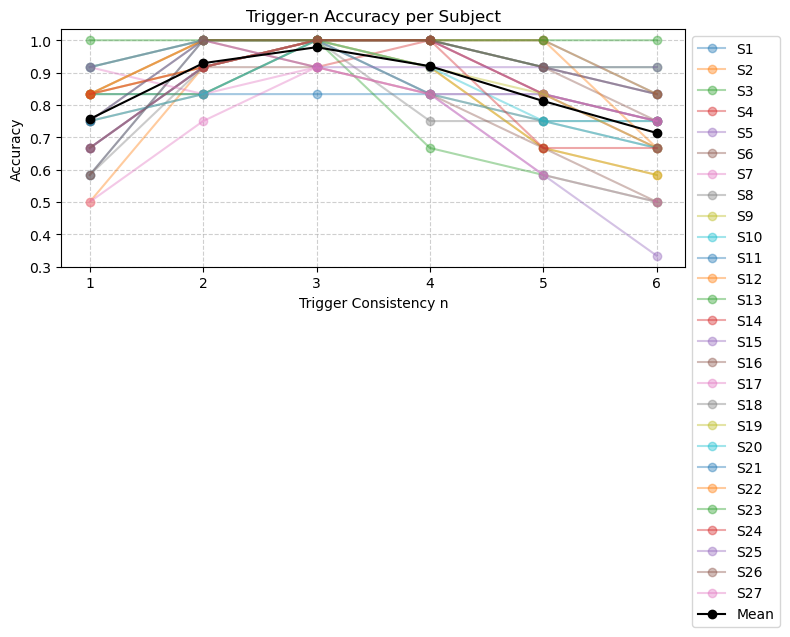

In [55]:
plt.figure(figsize=(8,5))
for i, subj in enumerate(subjects_results):
    plt.plot(n_list, subj["trigger_acc_list"], marker='o', alpha=0.4, label=f"S{i+1}")
plt.plot(n_list, mean_trigger_acc, marker='o', color='k', label='Mean')
plt.xlabel("Trigger Consistency n")
plt.ylabel("Accuracy")
plt.title("Trigger-n Accuracy per Subject")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


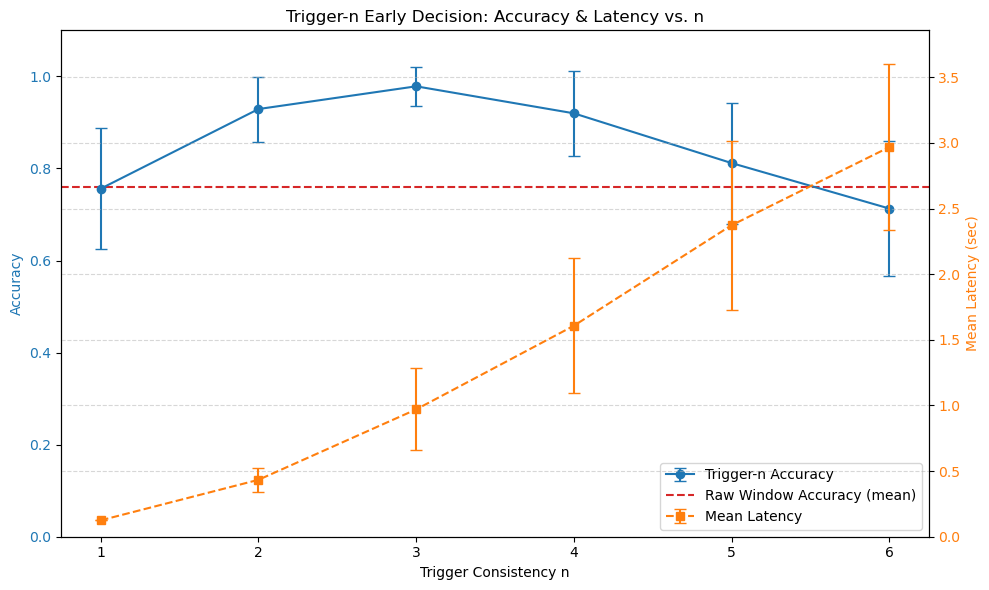

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# 假設以下是你的數據（請替換為真實的 subjects_results, mean_trigger_acc, std_trigger_acc, mean_latency, std_latency, n_list）
# subjects_results = [...]  # 你的subject results list
# mean_trigger_acc = [...]
# std_trigger_acc = [...]
# mean_latency = [...]
# std_latency = [...]
# n_list = [1, 2, 3, 4, 5, 6]

# 取平均raw_acc
mean_raw_acc = np.mean([s['raw_acc'] for s in subjects_results])

fig, ax1 = plt.subplots(figsize=(10, 6))

# --- Accuracy (Trigger-n & Raw) ---
color_acc = 'tab:blue'
ax1.set_xlabel("Trigger Consistency n")
ax1.set_ylabel("Accuracy", color=color_acc)
lns1 = ax1.errorbar(n_list, mean_trigger_acc, yerr=std_trigger_acc, marker='o', capsize=4, color=color_acc, label='Trigger-n Accuracy')
lns2 = ax1.axhline(mean_raw_acc, color='tab:red', linestyle='--', label='Raw Window Accuracy (mean)')
ax1.tick_params(axis='y', labelcolor=color_acc)
ax1.set_ylim(0, 1.1)

# --- Latency ---
ax2 = ax1.twinx()
color_lat = 'tab:orange'
ax2.set_ylabel("Mean Latency (sec)", color=color_lat)
lns3 = ax2.errorbar(n_list, mean_latency, yerr=std_latency, marker='s', capsize=4, color=color_lat, linestyle='--', label='Mean Latency')
ax2.tick_params(axis='y', labelcolor=color_lat)
ax2.set_ylim(0, max(mean_latency) * 1.3)

# --- 合併圖例 ---
lns = [lns1, lns2, lns3]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='lower right')

plt.title("Trigger-n Early Decision: Accuracy & Latency vs. n")
plt.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout()
plt.show()
